#  Servo System Performance Prediction using several models.

---

This notebook demonstrates the application and comparison of several regression models—**Support Vector Regression (SVR)**, **Artificial Neural Networks (ANN)**, **Polynomial Regression**, **Tree based models (XGBoost and Random Forest)**, and **K-Nearest Neighbor (KNN)**—to predict the rise time of a servo mechanism. The dataset contains information about different servo configurations, including:

- **Motor type** (categorical)
- **Screw type** (categorical)
- **Proportional gain** (continuous)
- **Velocity gain** (continuous)

The goal is to build and compare robust regression models that can accurately predict the rise time (class) based on these input features. We'll explore the data, preprocess it appropriately, train and evaluate SVR, ANN, Polynomial Regression, KNN, and Tree Based models, and compare their performance using various metrics.


## 1. Import Required Libraries

First, let's import all the necessary libraries for data loading, preprocessing, modeling, and visualization.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras

np.random.seed(42)

plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

2025-05-15 18:10:11.358525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 18:10:11.359315: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 18:10:11.364958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 18:10:11.375919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747329011.399099   26774 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747329011.40

## 2. Load and Explore the Dataset

Let's load the servo dataset and explore its structure.


In [2]:
column_names = ['motor', 'screw', 'pgain', 'vgain', 'class']

try:
    df = pd.read_csv('data/servo.data', header=None, names=column_names)
except FileNotFoundError:
    df = pd.read_csv('../data/servo.data', header=None, names=column_names)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (167, 5)


,motor,screw,pgain,vgain,class
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [3]:
df.describe(include='all')

,motor,screw,pgain,vgain,class
count,167,167,167.000000,167.000000,167.000000
unique,5,5,NaN,NaN,NaN
top,C,A,NaN,NaN,NaN
freq,40,42,NaN,NaN,NaN
mean,NaN,NaN,4.155689,2.538922,1.389708
std,NaN,NaN,1.017770,1.369850,1.559635
min,NaN,NaN,3.000000,1.000000,0.131250
25%,NaN,NaN,3.000000,1.000000,0.503126
50%,NaN,NaN,4.000000,2.000000,0.731254
75%,NaN,NaN,5.000000,4.000000,1.259369


In [4]:
print("Missing values:")
df.isnull().sum()

Missing values:


motor    0
screw    0
pgain    0
vgain    0
class    0
dtype: int64

## 3. Exploratory Data Analysis

Let's visualize the data to better understand the relationships between features and the target variable.


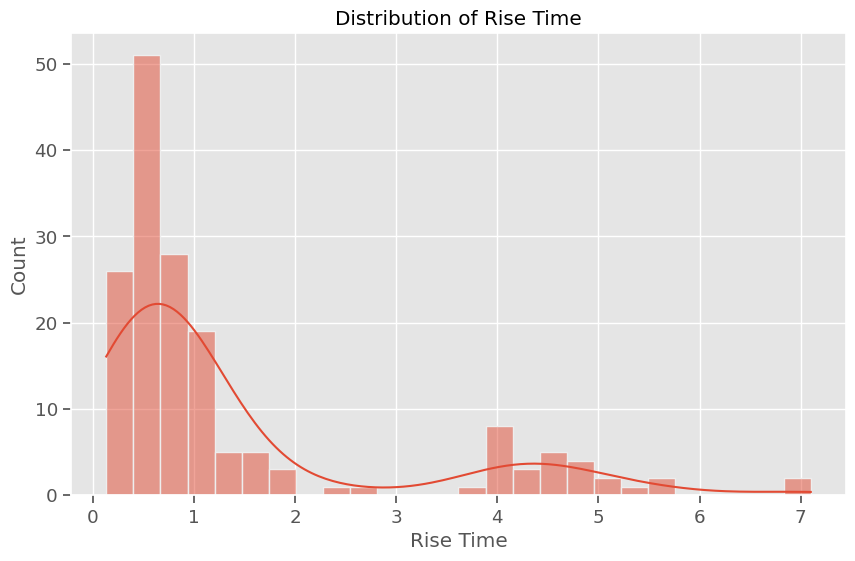

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['class'], kde=True)
plt.title('Distribution of Rise Time')
plt.xlabel('Rise Time')
plt.show()

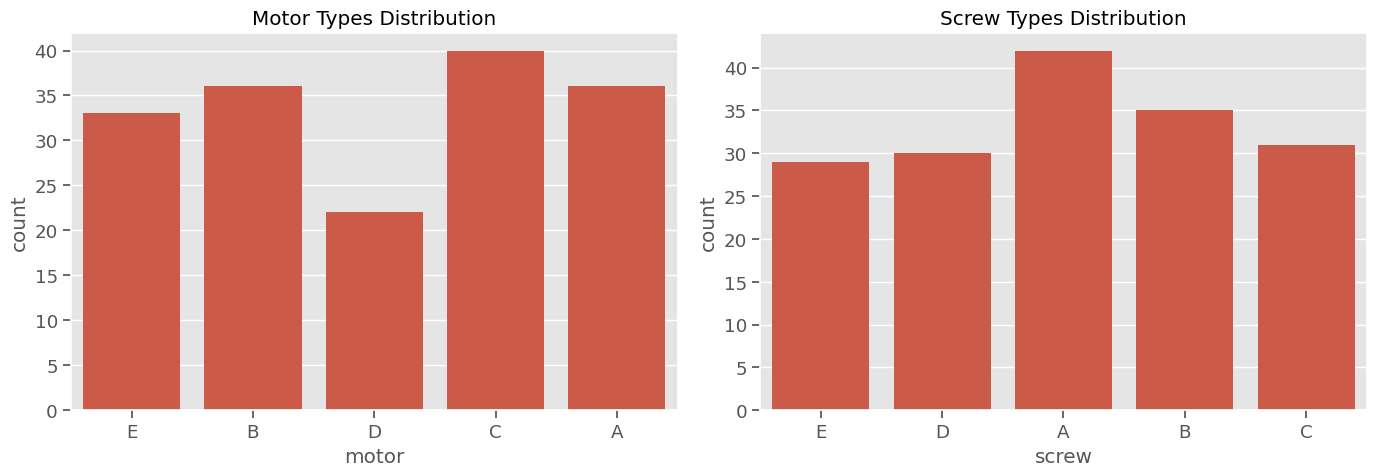

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='motor', data=df, ax=axes[0])
axes[0].set_title('Motor Types Distribution')
sns.countplot(x='screw', data=df, ax=axes[1])
axes[1].set_title('Screw Types Distribution')
plt.tight_layout()
plt.show()

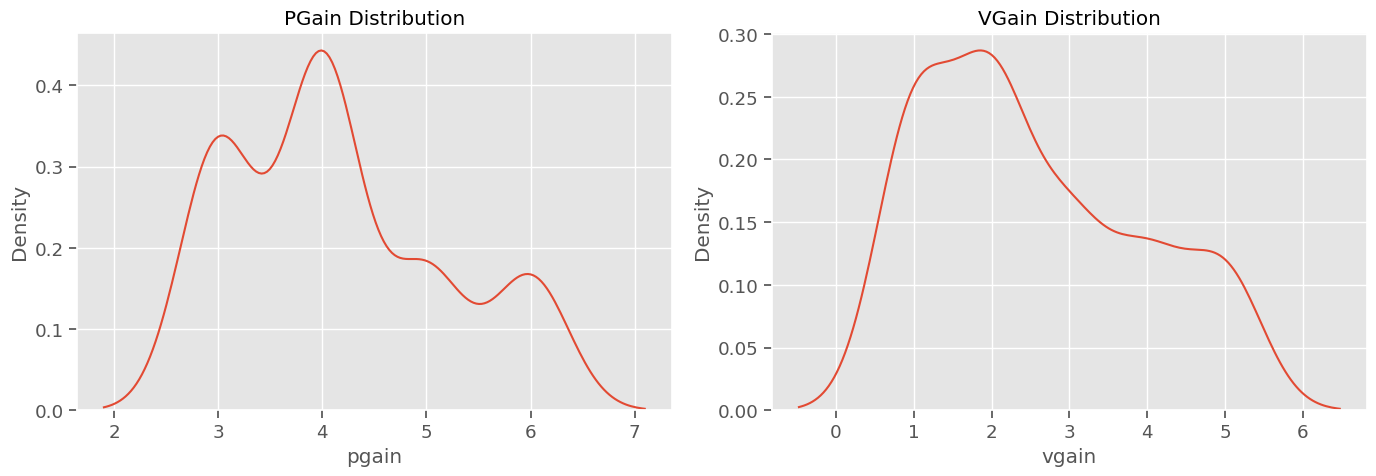

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(x='pgain', data=df, ax=axes[0])
axes[0].set_title('PGain Distribution')
sns.kdeplot(x='vgain', data=df, ax=axes[1])
axes[1].set_title('VGain Distribution')
plt.tight_layout()
plt.show()

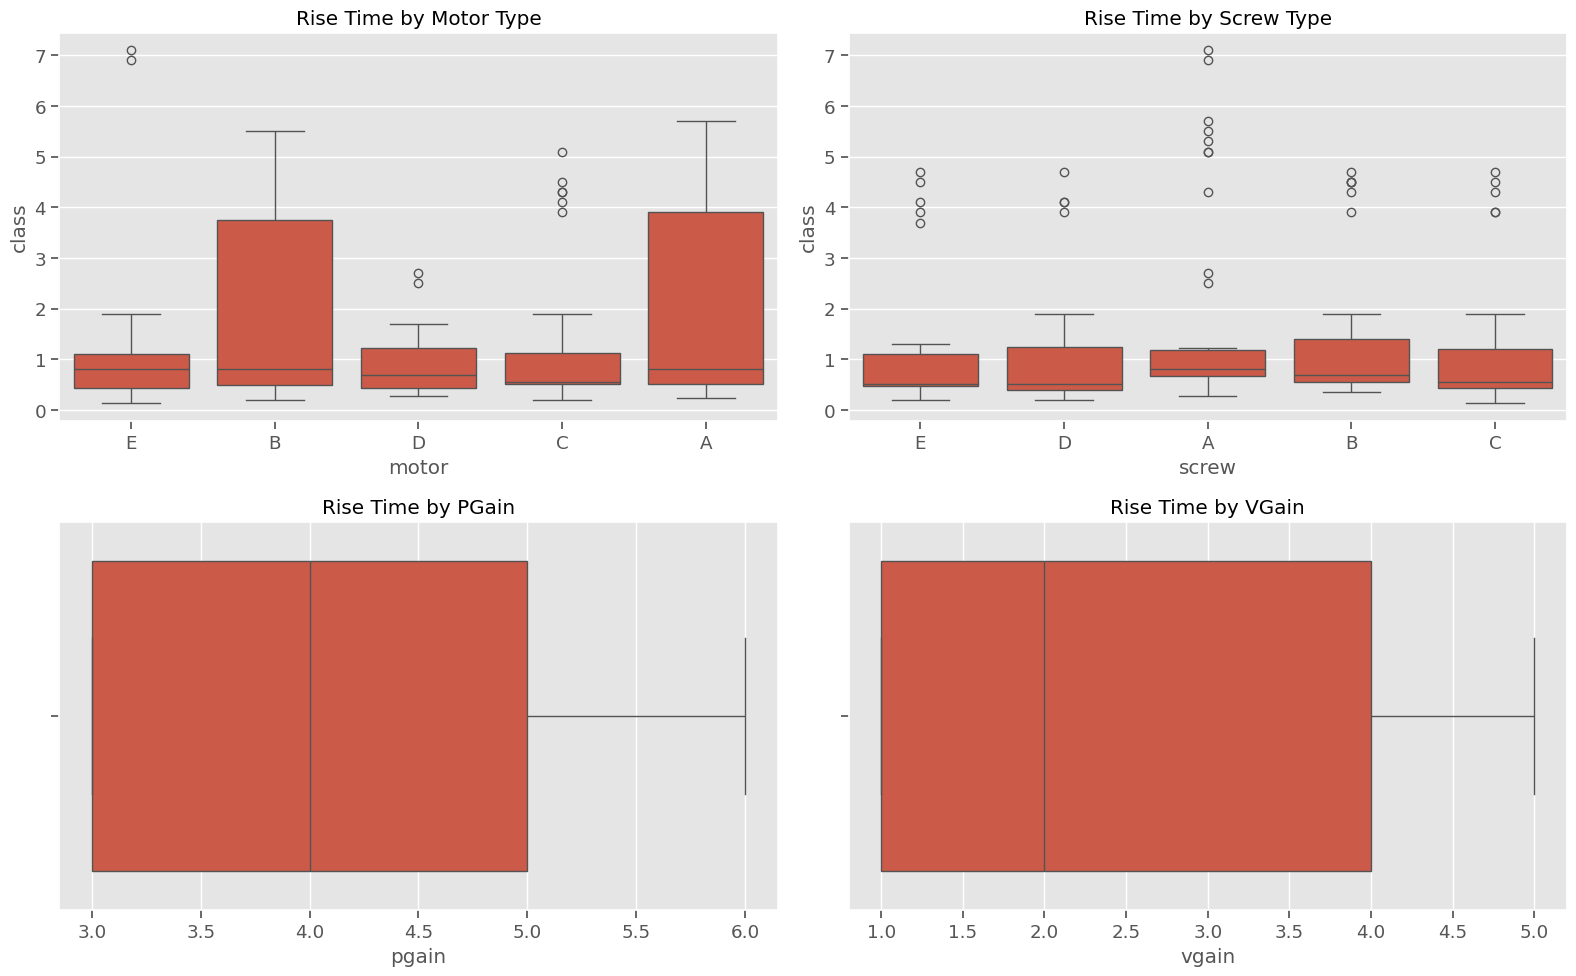

In [55]:
# Boxplot: Target value by categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.boxplot(x='motor', y='class', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Rise Time by Motor Type')
sns.boxplot(x='screw', y='class', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Rise Time by Screw Type')
sns.boxplot(x='pgain', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Rise Time by PGain')
sns.boxplot(x='vgain', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Rise Time by VGain')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Now let's preprocess the data for modeling. We need to handle the categorical variables using one-hot encoding.


In [9]:
X = df.drop('class', axis=1)
y = df['class']

categorical_cols = ['motor', 'screw']
numerical_cols = ['pgain', 'vgain']

X['pgain'] = pd.to_numeric(X['pgain'])
X['vgain'] = pd.to_numeric(X['vgain'])

split features to categorical and numerical


In [ ]:
num_features = df.select_dtypes(include=np.number).columns.drop('class').tolist()
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()
data = df


encode categorical features for random forest to run


In [12]:
dataset_encoded = pd.get_dummies(data, columns=cat_features, drop_first=True)
dataset_encoded

,pgain,vgain,class,motor_B,motor_C,motor_D,motor_E,screw_B,screw_C,screw_D,screw_E
0,5,4,0.281251,False,False,False,True,False,False,False,True
1,6,5,0.506252,True,False,False,False,False,False,True,False
2,4,3,0.356251,False,False,True,False,False,False,True,False
3,3,2,5.500033,True,False,False,False,False,False,False,False
4,6,5,0.356251,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
162,3,2,4.499986,True,False,False,False,False,True,False,False
163,3,1,3.699967,True,False,False,False,False,False,False,True
164,4,3,0.956256,False,True,False,False,False,False,True,False
165,3,2,4.499986,False,False,False,False,True,False,False,False


In [13]:
BX = dataset_encoded.drop(columns=['class'])
by = df['class']
BX_train, BX_test, _, _ = train_test_split(BX, by, test_size=0.2, random_state=42)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 133 samples
Testing set size: 34 samples


In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform and convert to dense float32 arrays for compatibility with TensorFlow
X_train_processed = preprocessor.transform(X_train).astype('float32')
X_test_processed = preprocessor.transform(X_test).astype('float32')

# Extract one-hot encoded feature names
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(ohe_feature_names) + numerical_cols

print("Feature names after preprocessing:")
print(all_feature_names)


Feature names after preprocessing:
['motor_B', 'motor_C', 'motor_D', 'motor_E', 'screw_B', 'screw_C', 'screw_D', 'screw_E', 'pgain', 'vgain']


## 5. Modeling


### 5.1. Artificial Neural Networks


Let's implement an artificial neural network and train it on the data


#### Model Architecture


- The neural network we are going to be using for this task consists of two hidden layers (the shallow layer contains 32 neurons and the deep one contains 16 neurons) and an output layer with one neuron
- The architecture of the model is specified below


In [16]:
ann_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_processed.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

E0000 00:00:1747329016.189874   26774 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747329016.191075   26774 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
# specifying the optimizer and the metrics to evaluate the model
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [18]:
history = ann_model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.9471 - mae: 0.7675 - val_loss: 3.9657 - val_mae: 1.1850
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.9647 - mae: 0.9092 - val_loss: 3.3278 - val_mae: 1.0884
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9984 - mae: 0.7594 - val_loss: 2.8098 - val_mae: 1.0030
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6402 - mae: 0.7077 - val_loss: 2.4088 - val_mae: 0.9594
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2317 - mae: 0.6786 - val_loss: 2.1292 - val_mae: 0.9253
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2559 - mae: 0.7200 - val_loss: 1.9486 - val_mae: 0.8960
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1981 - mae: 0.7163 - val_loss: 1.8291 - val_mae: 0.8686
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1678 - mae: 0.7370 - val_loss: 1.7246 - val_mae: 0.8409
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5260 - mae: 

#### Evaluation of the model


In [19]:
# Ensure y_test is a float32 NumPy array
y_test = y_test.astype('float32')

# Make predictions on the test set
y_pred_ann = ann_model.predict(X_test_processed)
tr_y_pred = ann_model.predict(X_train_processed)

# Flatten predictions if needed (in case they are shape (n, 1))
y_pred_ann = y_pred_ann.flatten()
y_pred_ann[y_pred_ann < 0] = 0

tr_y_pred = tr_y_pred.flatten()

# Evaluate the model
mse_ann = mean_squared_error(y_test, y_pred_ann)
tr_mse = mean_squared_error(y_train, tr_y_pred)

rmse_ann = np.sqrt(mse_ann)
tr_rmse = np.sqrt(tr_mse)

mae_ann = mean_absolute_error(y_test, y_pred_ann)
tr_mae = mean_absolute_error(y_train, tr_y_pred)

r2_ann = r2_score(y_test, y_pred_ann)
tr_r2 = r2_score(y_train, tr_y_pred)

print(f"Train Mean Squared Error: {tr_mse:.4f}")
print(f"Test Mean Squared Error: {mse_ann:.4f}")
print(f"Train Root Mean Squared Error: {tr_rmse:.4f}")
print(f"Test Root Mean Squared Error: {rmse_ann:.4f}")
print(f"Train Mean Absolute Error: {tr_mae:.4f}")
print(f"Test Mean Absolute Error: {mae_ann:.4f}")
print(f"Train R² Score: {tr_r2:.4f}")
print(f"Test R² Score: {r2_ann:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Train Mean Squared Error: 0.1137
Test Mean Squared Error: 0.2003
Train Root Mean Squared Error: 0.3372
Test Root Mean Squared Error: 0.4476
Train Mean Absolute Error: 0.1257
Test Mean Absolute Error: 0.3426
Train R² Score: 0.9528
Test R² Score: 0.9172


#### Visualizing Model Performance


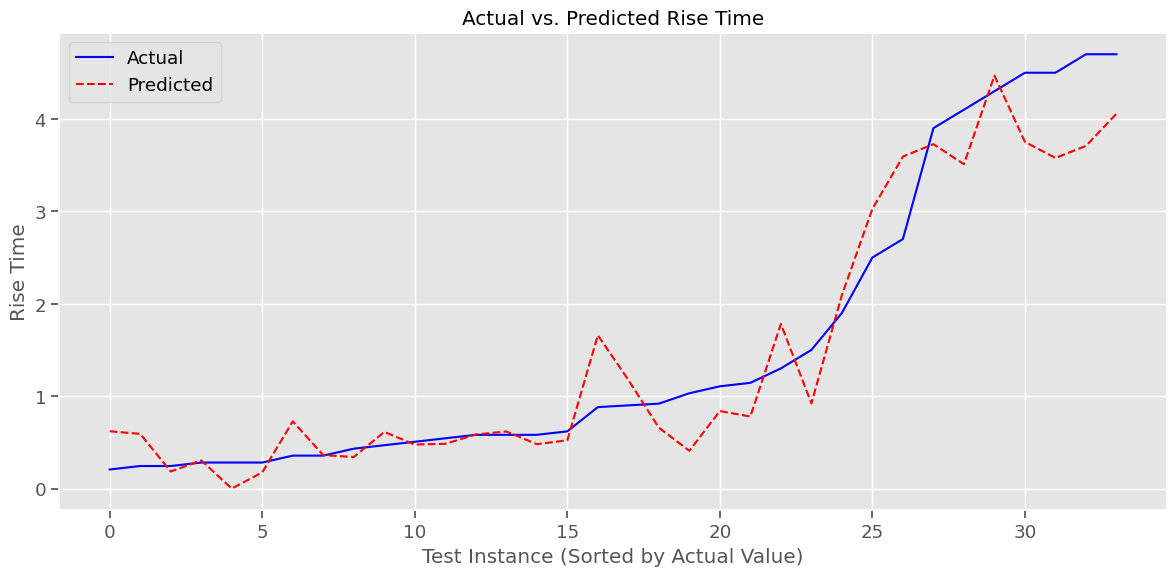

In [20]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_ann})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

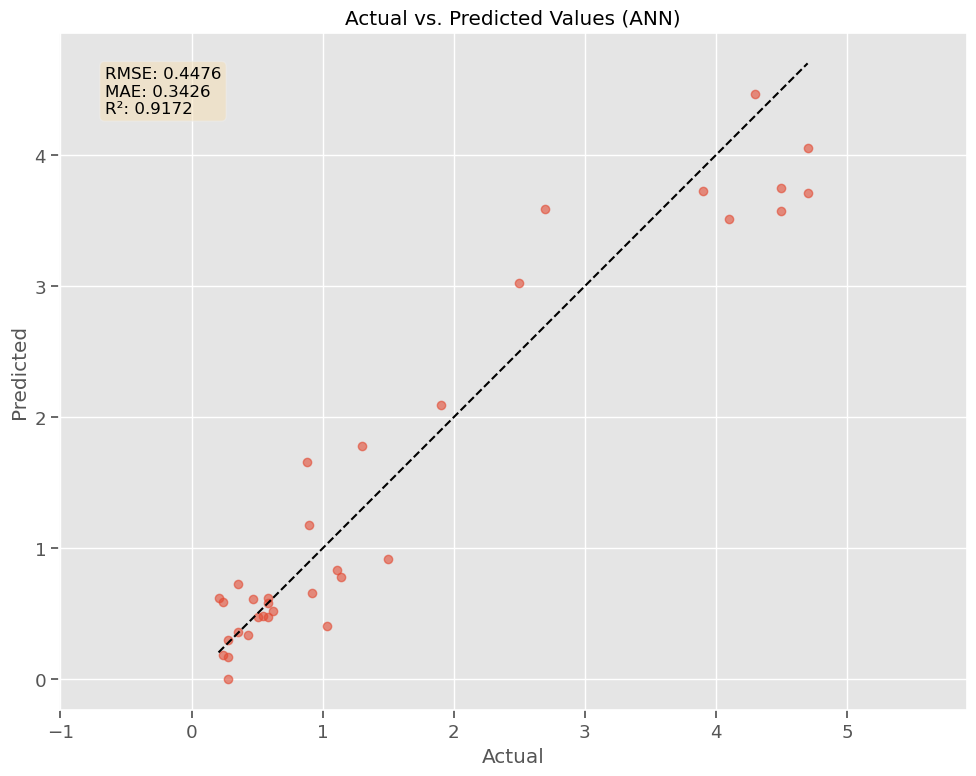

In [21]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_ann, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (ANN)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred_ann.max() - y_pred_ann.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse_ann:.4f}',
    f'MAE: {mae_ann:.4f}',
    f'R²: {r2_ann:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

### 5.2. Support Vector Regression Implementation

Let's implement the SVR model and optimize its hyperparameters using GridSearchCV.


In [22]:
import time
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV

# Create the SVR pipeline
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Define hyperparameter grid for SVR
param_grid = {
    'regressor__kernel': ['linear', 'rbf', 'poly'],
    'regressor__C': [0.01, 0.1, 1, 10, 100],
    'regressor__epsilon': [0.001, 0.01, 0.1, 0.2, 0.5],
    'regressor__gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    'regressor__degree': [2, 3],
    'regressor__coef0': [0.0, 1.0],
    'regressor__shrinking': [True, False]
}

# Print the total number of combinations
total_combinations = 3 * 5 * 5 * 5 * 2 * 2 * 2
print(f"Total parameter combinations: {total_combinations}")
print(f"Starting grid search at {datetime.now().strftime('%H:%M:%S')}")

# Choose which search method to use
use_randomized_search = True  # Set to False to use full grid search

if use_randomized_search:
    # Use RandomizedSearchCV for more efficient search
    print("Using RandomizedSearchCV with 100 iterations instead of full grid search")
    start_time = time.time()
    
    search = RandomizedSearchCV(
        svr_pipeline,
        param_distributions=param_grid,
        n_iter=100,  # Sample 100 parameter combinations
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2,  # More verbose output
        n_jobs=-1,
        random_state=42
    )
else:
    # Use full GridSearchCV (may take a long time)
    print("Using full GridSearchCV with all parameter combinations")
    start_time = time.time()
    
    search = GridSearchCV(
        svr_pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2,  # More verbose output
        n_jobs=-1
    )

# Fit the search
search.fit(X_train, y_train)

# Calculate and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\nSearch completed at {datetime.now().strftime('%H:%M:%S')}")
print(f"Total execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

# Get the best parameters and best score
print("\nBest parameters:", search.best_params_)
print("Best cross-validation score: {:.4f}".format(-search.best_score_))

# Assign to grid_search for use in subsequent cells
grid_search = search

Total parameter combinations: 3000
Starting grid search at 18:10:32
Using RandomizedSearchCV with 100 iterations instead of full grid search
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END regressor__C=10, regressor__coef0=0.0, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=linear, regressor__shrinking=False; total time=   0.1s
[CV] END regressor__C=0.1, regressor__coef0=1.0, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.1, regressor__kernel=rbf, regressor__shrinking=True; total time=   0.0s
[CV] END regressor__C=0.1, regressor__coef0=1.0, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.1, regressor__kernel=rbf, regressor__shrinking=True; total time=   0.0s
[CV] END regressor__C=10, regressor__coef0=0.0, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.01, regressor__kernel=poly, regressor__shrinking=False; total time=   0.0s
[CV] END regressor__C=0.1, regressor__coef0=1

#### Evaluation of the model


In [23]:
# Get the best model
best_svr = grid_search.best_estimator_

# Make predictions on the test set
y_pred_svr = best_svr.predict(X_test)
y_pred_svr[y_pred_svr < 0] = 0

tr_y_pred_svr = best_svr.predict(X_train)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
r2_tr = r2_score(y_train, tr_y_pred_svr)

print(f"Mean Squared Error: {mse_svr:.4f}")
print(f"Root Mean Squared Error: {rmse_svr:.4f}")
print(f"Mean Absolute Error: {mae_svr:.4f}")
print(f"Test R² Score: {r2_svr:.4f}")
print(f"TRain R² Score: {r2_tr:.4f}")

Mean Squared Error: 0.1054
Root Mean Squared Error: 0.3247
Mean Absolute Error: 0.2625
Test R² Score: 0.9564
TRain R² Score: 0.8895


#### Visualizing Model Performance

Let's visualize how well our model predictions match the actual values.


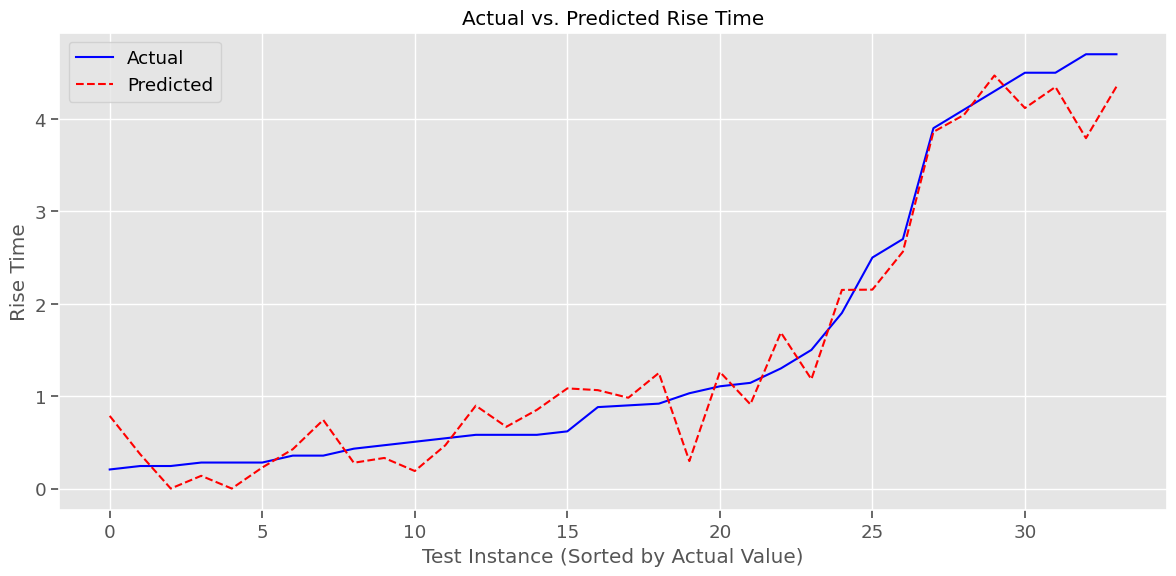

In [24]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svr})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

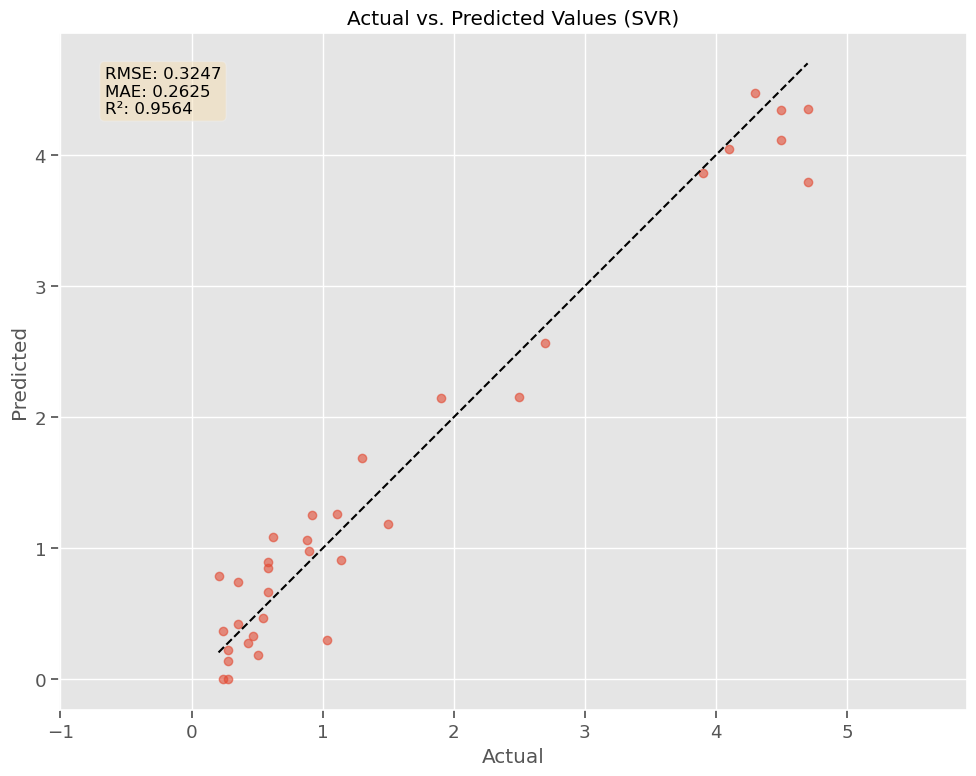

In [25]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_svr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (SVR)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred_svr.max() - y_pred_svr.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse_svr:.4f}',
    f'MAE: {mae_svr:.4f}',
    f'R²: {r2_svr:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

### 5.3. Linear & Quadratic Regression Implementation


First, let's see which degree of the polynomial is the best fit, using 10-Fold cross validation approach, since the size of the dataset is small (167 instances)


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error


def choose_best_polynomial_degree(X_train, y_train, degrees=[1, 2, 3], k=10, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    avg_rmse_per_degree = {}

    y_train_array = np.asarray(y_train)

    for degree in degrees:
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X_train)
        rmse_list = []

        for train_index, val_index in kf.split(X_poly):
            X_tr, X_val = X_poly[train_index], X_poly[val_index]
            y_tr, y_val = y_train_array[train_index], y_train_array[val_index]

            model = LinearRegression()
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            rmse = root_mean_squared_error(y_val, y_pred)
            rmse_list.append(rmse)

        avg_rmse = np.mean(rmse_list)
        avg_rmse_per_degree[degree] = avg_rmse
        print(f"Degree {degree}: 10-Fold CV Avg RMSE = {avg_rmse:.4f}")

    best_degree = min(avg_rmse_per_degree, key=avg_rmse_per_degree.get)
    print(f"\nBest degree based on 10-Fold CV: {best_degree}")
    return best_degree



In [27]:
best_deg = choose_best_polynomial_degree(X_train_processed, y_train)


Degree 1: 10-Fold CV Avg RMSE = 1.1625
Degree 2: 10-Fold CV Avg RMSE = 1.0082
Degree 3: 10-Fold CV Avg RMSE = 256.3918

Best degree based on 10-Fold CV: 2


As you can see, The best fit is the quadratic fit, it is slightly better than the linear fit which underfits the data


#### Evaluation of the model


In [28]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_processed)
X_test_poly = poly.transform(X_test_processed)

# Fit linear regression on polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on validation set
y_pred_quad = model.predict(X_test_poly)
y_pred_quad[y_pred_quad < 0] = 0

tr_y_pred_quad = model.predict(X_train_poly)

# Evaluate the model
mse_quad = mean_squared_error(y_test, y_pred_quad)
rmse_quad = np.sqrt(mse_quad)
mae_quad = mean_absolute_error(y_test, y_pred_quad)
r2_quad = r2_score(y_test, y_pred_quad)
r2_tr = r2_score(y_train, tr_y_pred_quad)

print(f"Mean Squared Error: {mse_quad:.4f}")
print(f"Root Mean Squared Error: {rmse_quad:.4f}")
print(f"Mean Absolute Error: {mae_quad:.4f}")
print(f"Test R² Score: {r2_quad:.4f}")
print(f"TRain R² Score: {r2_tr:.4f}")

Mean Squared Error: 0.2745
Root Mean Squared Error: 0.5239
Mean Absolute Error: 0.4319
Test R² Score: 0.8865
TRain R² Score: 0.8518


We can see that our model is generalizable, since the R2 score of the training set is approximate to R2 score of the test set.


#### Visualizing Model Performance


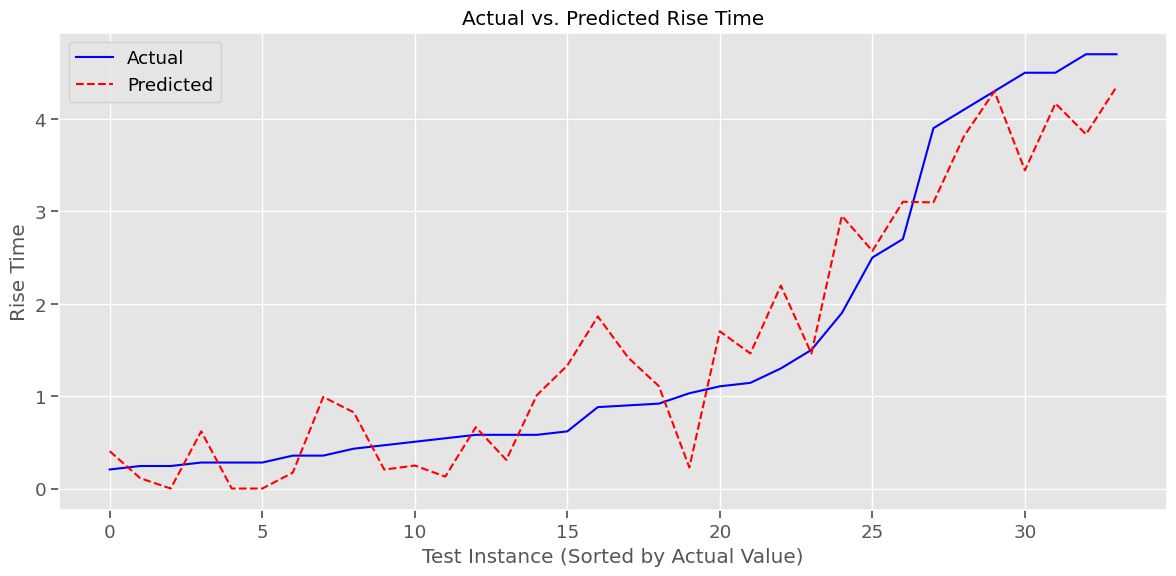

In [29]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_quad})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

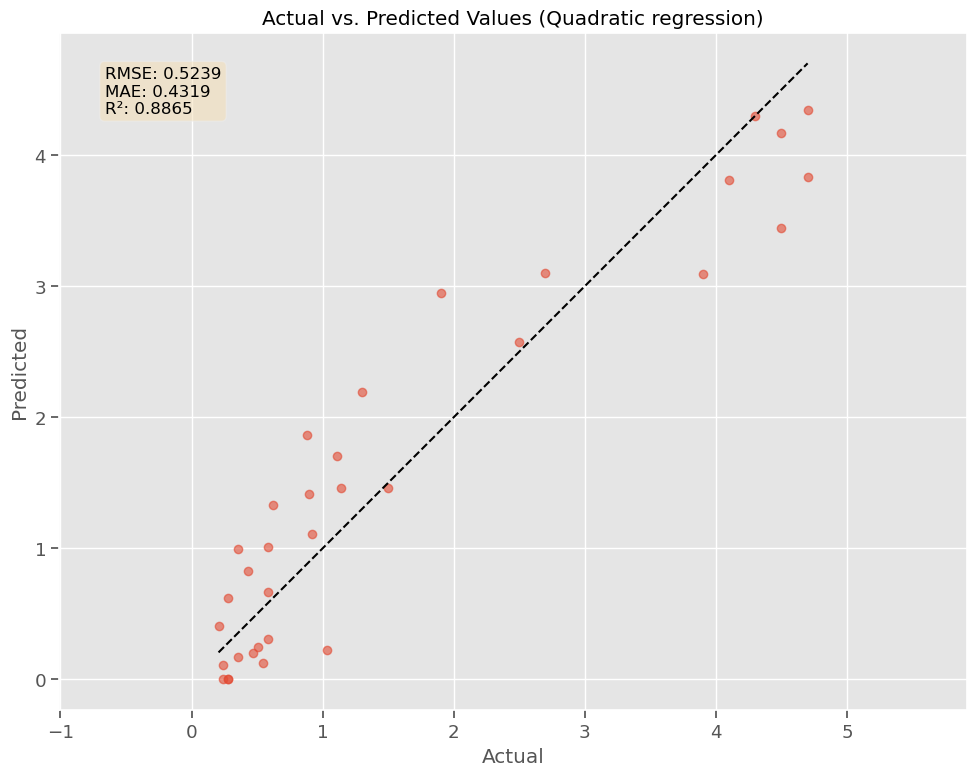

In [30]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_quad, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Quadratic regression)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred_quad.max() - y_pred_quad.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse_quad:.4f}',
    f'MAE: {mae_quad:.4f}',
    f'R²: {r2_quad:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

### 5.4. Tree Based Models Implementation (Random Forest and XGBoost)



In [31]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

getting best parameters for the random forest model


In [32]:

grid_params = {
    'n_estimators': [50, 100, 200, 250, 300],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}
rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=grid_params, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search_rf.fit(BX_train, y_train)

/home/abderrahmene-tliba/anaconda3/envs/DM_ENV/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 250, 300]},
             scoring='neg_mean_squared_error')

In [33]:
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)

Best parameters for Random Forest:
{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}


getting the best parameters for XGBoost model


In [34]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],               # Typical values for boosting
    'learning_rate': [0.01, 0.1, 0.3],     # Boosting step size
    'subsample': [0.6, 0.8, 1.0],          # Row sampling
    'colsample_bytree': [0.6, 0.8, 1.0]    # Feature sampling
}

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')  # 'reg:squarederror' for regression

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                               cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

grid_search_xgb.fit(BX_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [35]:
print("Best parameters for XGBoost:")
print(grid_search_xgb.best_params_)


Best parameters for XGBoost:
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.6}


#### Evaluation of the models


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Get best models
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_

# Predict
y_pred_rf = best_rf.predict(BX_test)
y_pred_rf[y_pred_rf < 0] = 0

tr_y_pred_rf = best_rf.predict(BX_train)
y_pred_xgb = best_xgb.predict(BX_test)
y_pred_xgb[y_pred_xgb < 0] = 0

tr_y_pred_xgb = best_xgb.predict(BX_train)


- Random Forest Evaluation :

In [37]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
r2_tr_rf = r2_score(y_train, tr_y_pred_rf)

print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"Root Mean Squared Error: {rmse_rf:.4f}")
print(f"Mean Absolute Error: {mae_rf:.4f}")
print(f"Test R² Score: {r2_rf:.4f}")
print(f"TRain R² Score: {r2_tr_rf:.4f}")

Mean Squared Error: 0.3511
Root Mean Squared Error: 0.5926
Mean Absolute Error: 0.4468
Test R² Score: 0.8548
TRain R² Score: 0.9428


- XGBoost Evaluation :

In [38]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_tr_xgb = r2_score(y_train, tr_y_pred_xgb)

print(f"Mean Squared Error: {mse_xgb:.4f}")
print(f"Root Mean Squared Error: {rmse_xgb:.4f}")
print(f"Mean Absolute Error: {mae_xgb:.4f}")
print(f"Test R² Score: {r2_xgb:.4f}")
print(f"TRain R² Score: {r2_tr_xgb:.4f}")

Mean Squared Error: 0.3579
Root Mean Squared Error: 0.5983
Mean Absolute Error: 0.4222
Test R² Score: 0.8520
TRain R² Score: 0.9148


#### Visualizing Models Performance


- Random Forest :

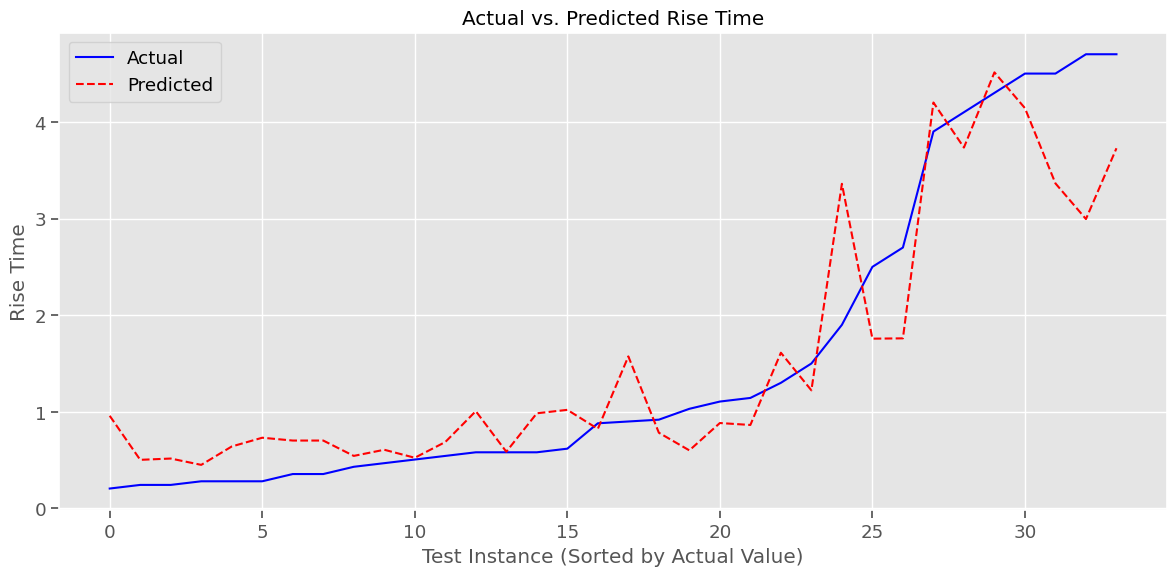

In [39]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

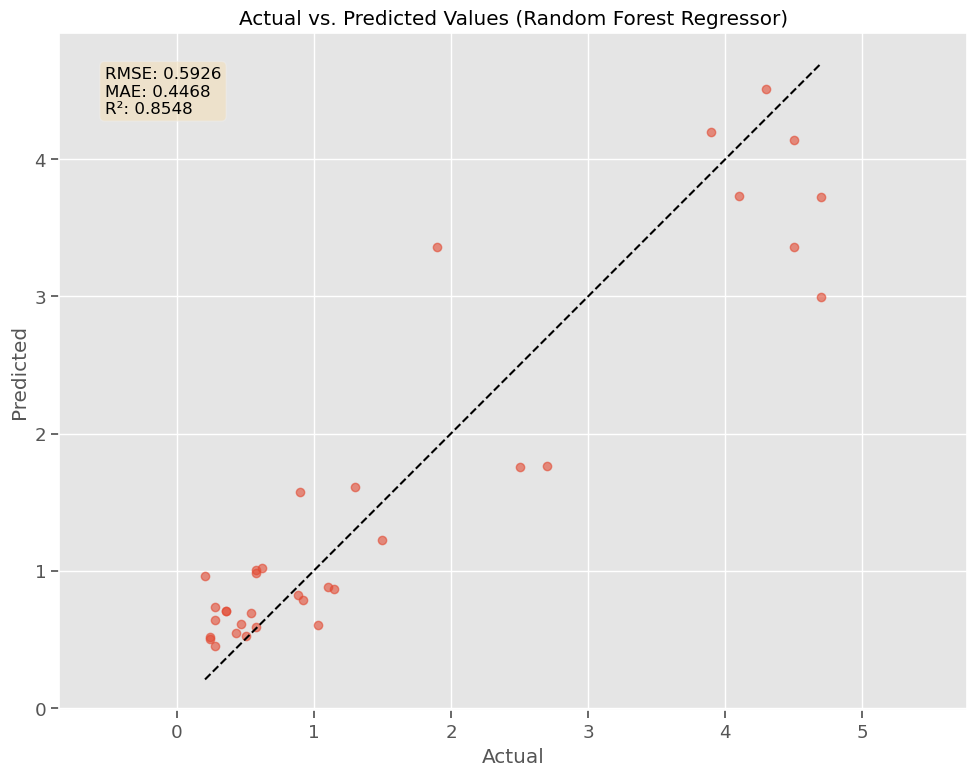

In [40]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Random Forest Regressor)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred_rf.max() - y_pred_rf.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse_rf:.4f}',
    f'MAE: {mae_rf:.4f}',
    f'R²: {r2_rf:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

- XGBoost :

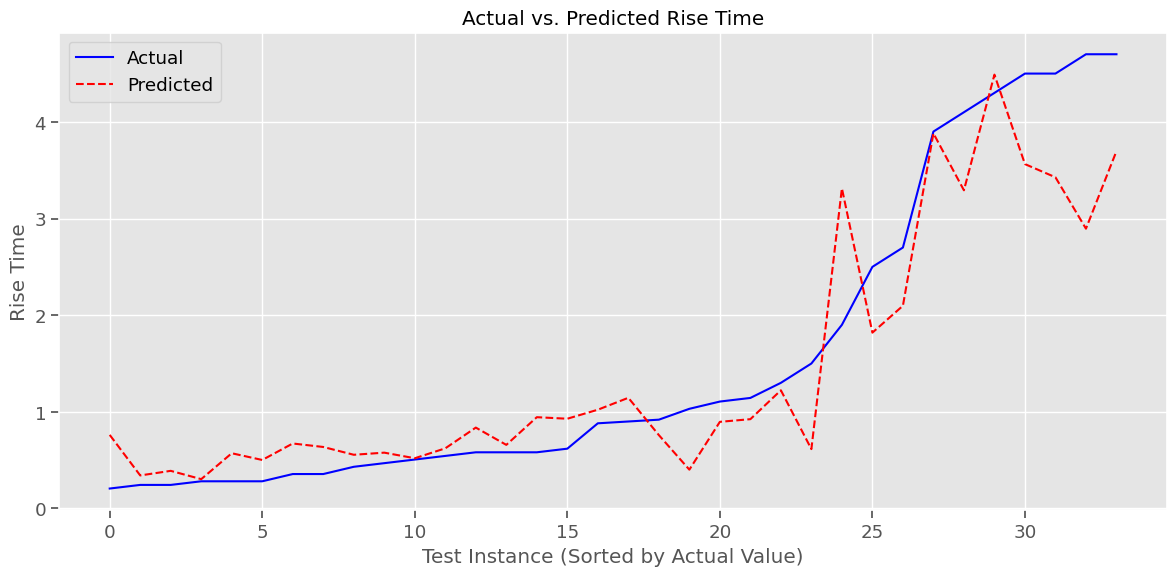

In [41]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_xgb})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

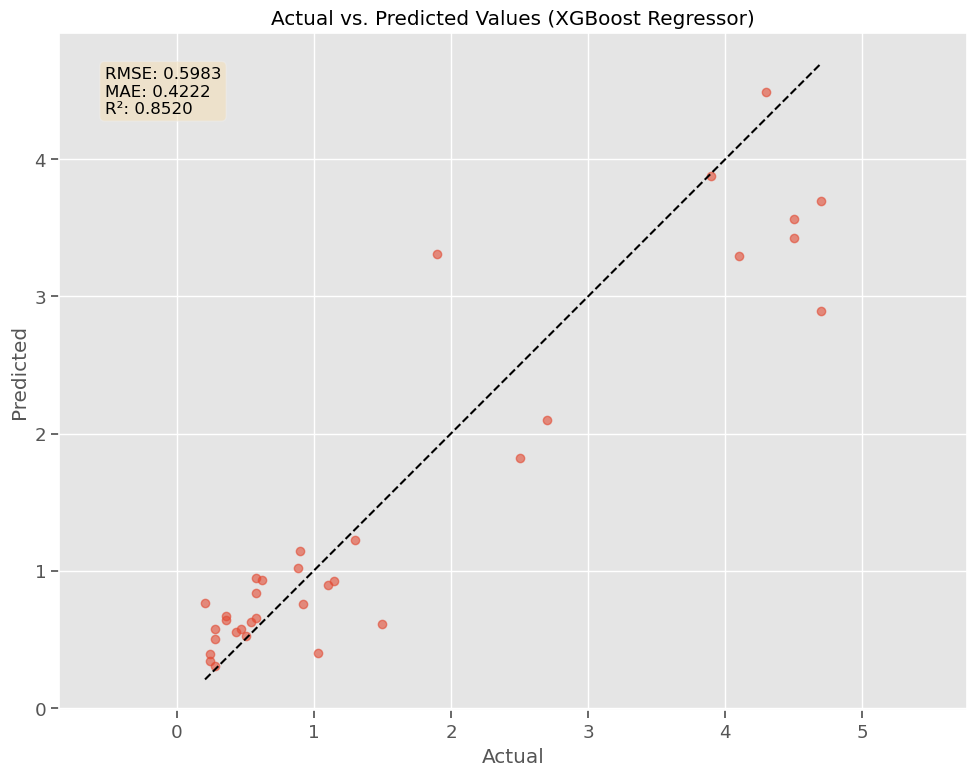

In [42]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (XGBoost Regressor)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred_xgb.max() - y_pred_xgb.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse_xgb:.4f}',
    f'MAE: {mae_xgb:.4f}',
    f'R²: {r2_xgb:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

#### Feature importance for tree based models


- Random Forest :

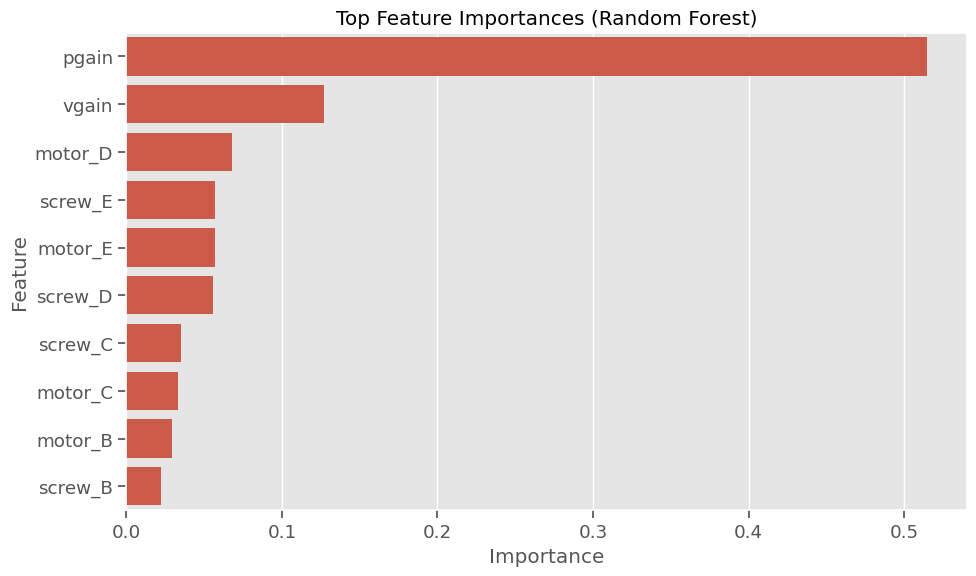

In [43]:
importances = best_rf.feature_importances_
feature_names = BX.columns
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(20))  # Top 20 features
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


- XGBoost :

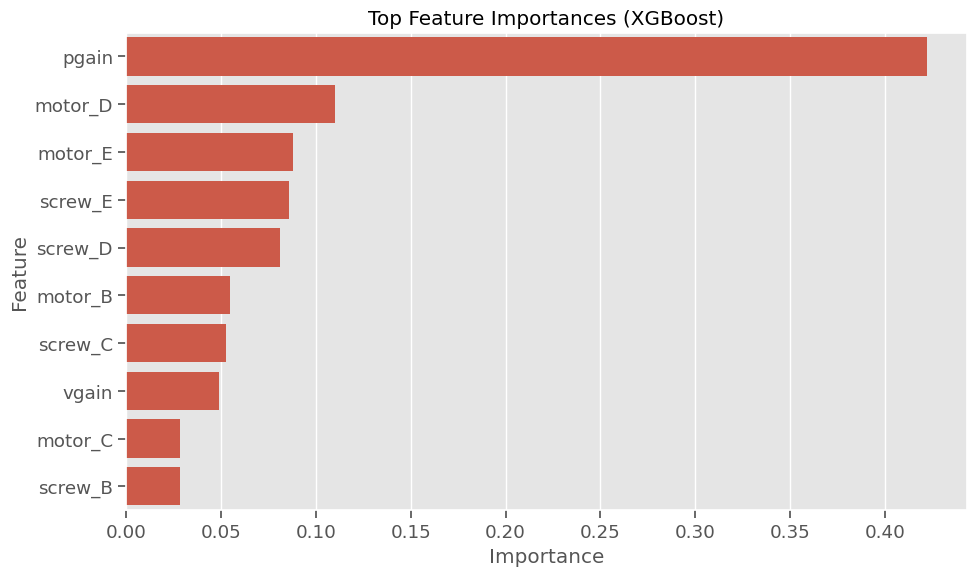

In [44]:
importances = best_xgb.feature_importances_
feature_names = BX.columns
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(20))  # Top 20 features
plt.title("Top Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


### 5.5. K-Nearest Neighbors (KNN) Implementation

In [45]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import cross_val_score

#  Initial Model to get a baseline
knn = KNeighborsRegressor()
knn.fit(BX_train, y_train)
y_pred_knn = knn.predict(BX_test)
tr_y_pred_knn = knn.predict(BX_train)

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
r2_tr_knn = r2_score(y_train, tr_y_pred_knn)

print(f"Mean Squared Error: {mse_knn:.4f}")
print(f"Root Mean Squared Error: {rmse_knn:.4f}")
print(f"Mean Absolute Error: {mae_knn:.4f}")
print(f"Test R² Score: {r2_knn:.4f}")
print(f"TRain R² Score: {r2_tr_knn:.4f}")

Mean Squared Error: 0.8576
Root Mean Squared Error: 0.9261
Mean Absolute Error: 0.6858
Test R² Score: 0.6455
TRain R² Score: 0.7226


doing Grid Search technique to get best parameters for KNN, using cross-validation, to prevent overfitting

In [46]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 (Manhattan), p=2 (Euclidean)
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, 
                           cv=5, scoring='neg_root_mean_squared_error', 
                           n_jobs=-1, verbose=1)
grid_search.fit(BX_train, y_train)

# Best Parameters
print("\nBest Parameters Found:")
print(grid_search.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best Parameters Found:
{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


#### Evaluation of the model

In [47]:
# Evaluate Best Model
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(BX_test)
y_pred_knn[y_pred_knn < 0] = 0

tr_y_pred_knn = best_knn.predict(BX_train)

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
r2_tr_knn = r2_score(y_train, tr_y_pred_knn)

print(f"Mean Squared Error: {mse_knn:.4f}")
print(f"Root Mean Squared Error: {rmse_knn:.4f}")
print(f"Mean Absolute Error: {mae_knn:.4f}")
print(f"Test R² Score: {r2_knn:.4f}")
print(f"TRain R² Score: {r2_tr_knn:.4f}")

Mean Squared Error: 0.8284
Root Mean Squared Error: 0.9102
Mean Absolute Error: 0.7010
Test R² Score: 0.6575
TRain R² Score: 0.7026


#### Visualizing Models Performance


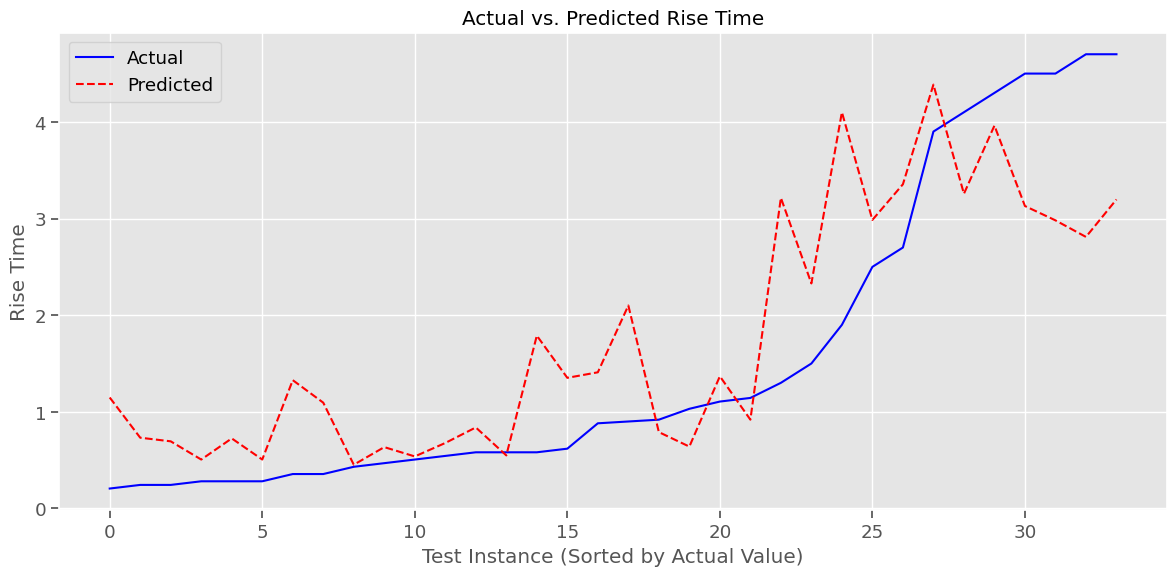

In [48]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_knn})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

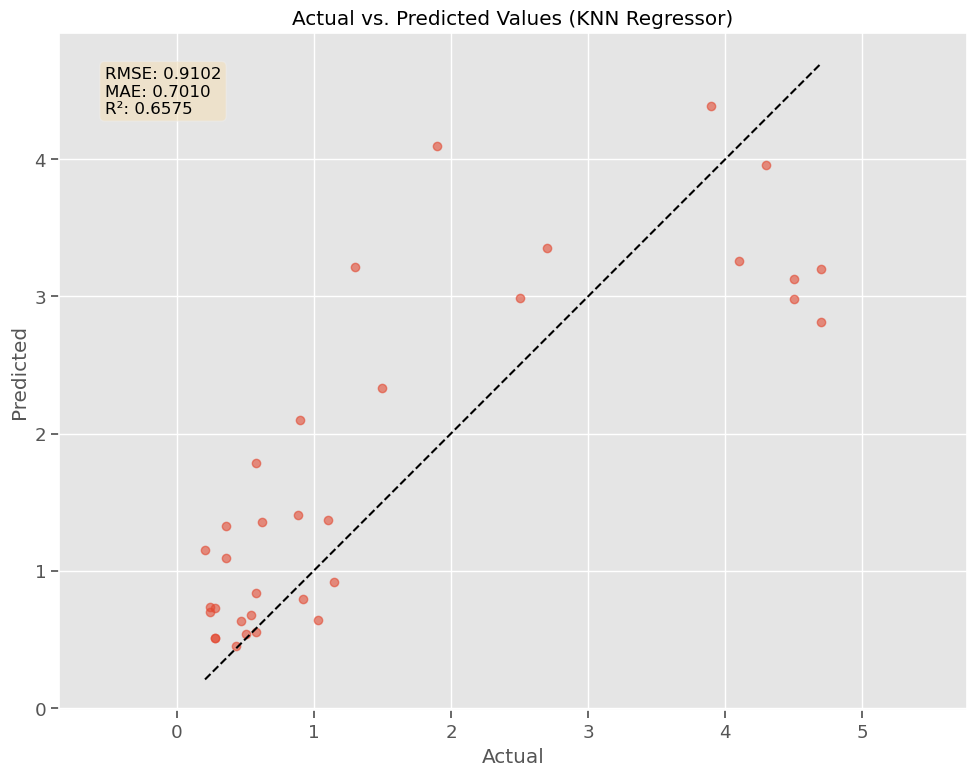

In [49]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_knn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (KNN Regressor)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred_knn.max() - y_pred_knn.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse_knn:.4f}',
    f'MAE: {mae_knn:.4f}',
    f'R²: {r2_knn:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

- Remark : The target represents Rise Time, and the time must be positive (cannot negative), so all negative predictions are set to 0 for all models, this makes the models more realistic

## 6.Model comparison


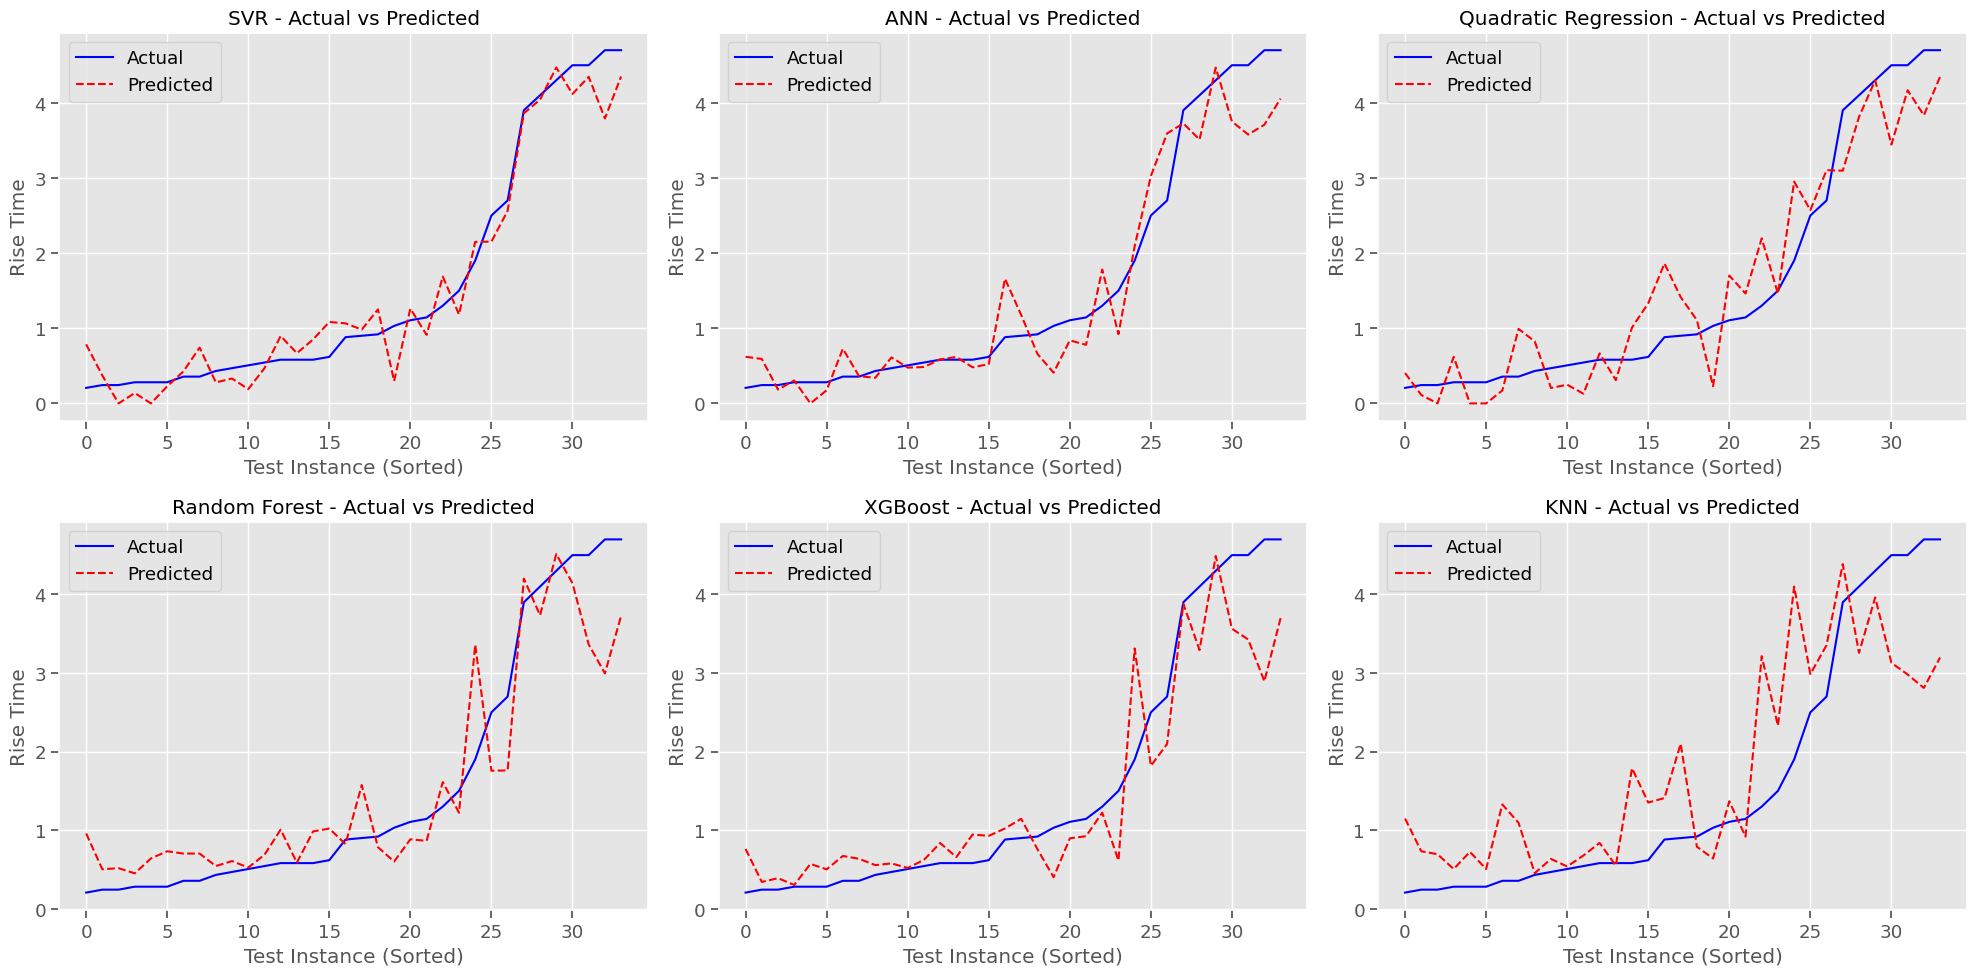

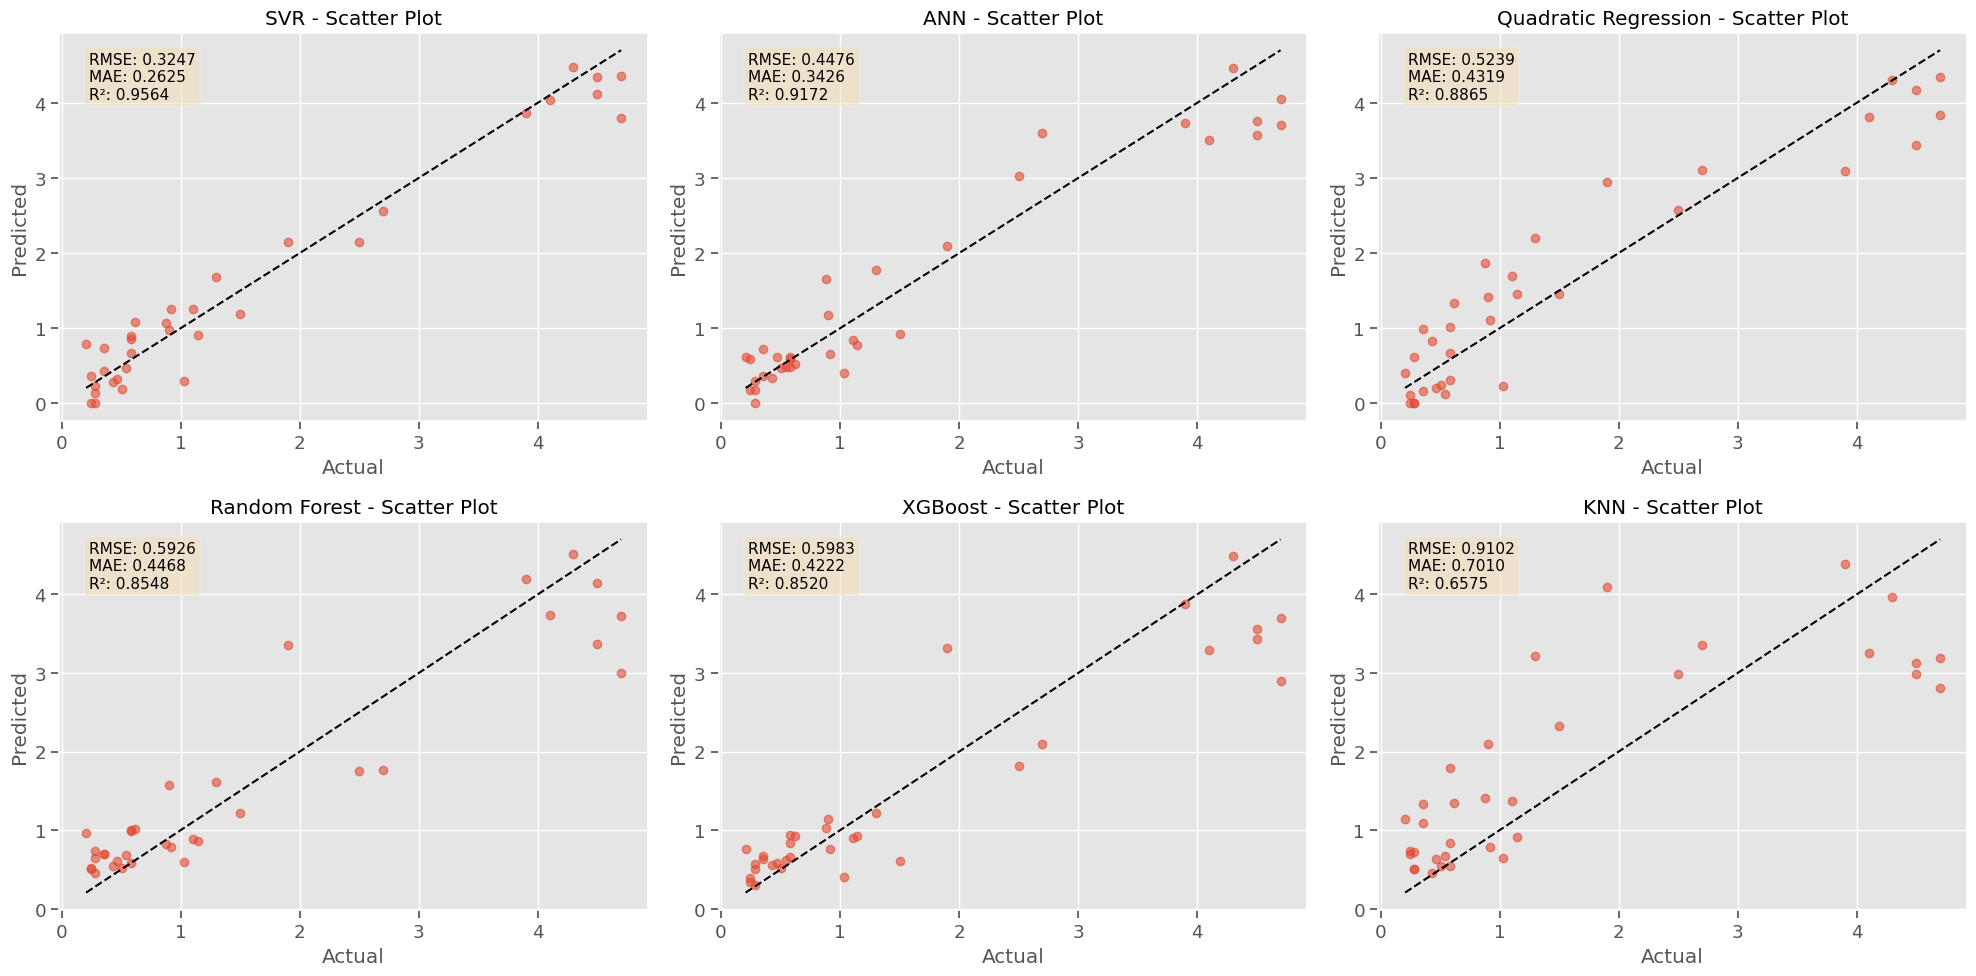

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# All model names
models = ['SVR', 'ANN', 'Quadratic Regression', 'Random Forest', 'XGBoost', 'KNN']

# Predictions for each model (ensure all y_pred_* variables are defined)
predictions = [y_pred_svr, y_pred_ann, y_pred_quad, y_pred_rf, y_pred_xgb, y_pred_knn]

# Evaluation metrics: (RMSE, MAE, R2)
metrics = [
    (rmse_svr, mae_svr, r2_svr),
    (rmse_ann, mae_ann, r2_ann),
    (rmse_quad, mae_quad, r2_quad),
    (rmse_rf, mae_rf, r2_rf),
    (rmse_xgb, mae_xgb, r2_xgb),
    (rmse_knn, mae_knn, r2_knn)
]

# --------- Line Plots: Actual vs Predicted ----------
plt.figure(figsize=(20, 10))
for i, (model, y_pred) in enumerate(zip(models, predictions)):
    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    results_df = results_df.sort_values(by='Actual')

    plt.subplot(2, 3, i+1)
    plt.plot(results_df['Actual'].values, 'b-', label='Actual')
    plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
    plt.title(f'{model} - Actual vs Predicted')
    plt.xlabel('Test Instance (Sorted)')
    plt.ylabel('Rise Time')
    plt.legend()
    plt.tight_layout()

plt.show()

# --------- Scatter Plots with Metrics ----------
plt.figure(figsize=(20, 10))
for i, (model, y_pred, (rmse, mae, r2)) in enumerate(zip(models, predictions, metrics)):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model} - Scatter Plot')

    # Add metrics
    textstr = '\n'.join((
        f'RMSE: {rmse:.4f}',
        f'MAE: {mae:.4f}',
        f'R²: {r2:.4f}'
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
             verticalalignment='top', bbox=props)
    plt.grid(True)

plt.tight_layout()
plt.show()


## 7. Residual Analysis

Let's analyze the residuals (prediction errors) to check for patterns or bias in our models.


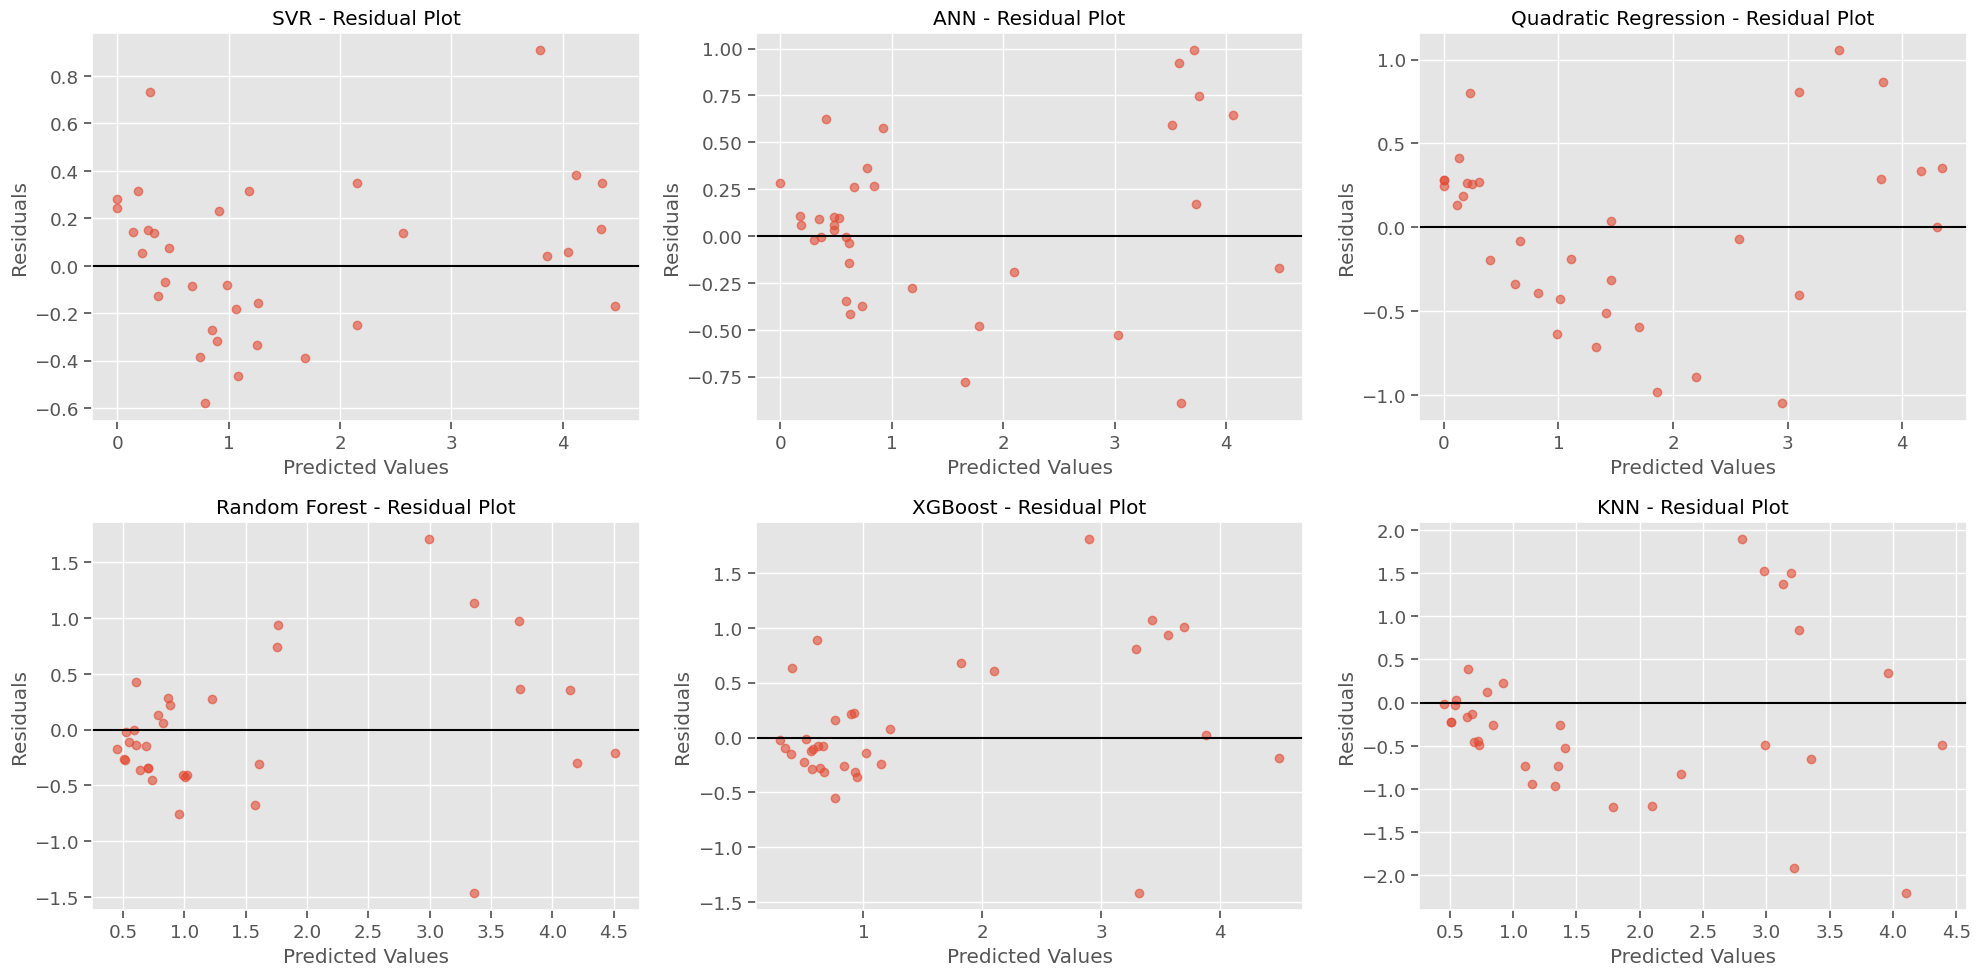

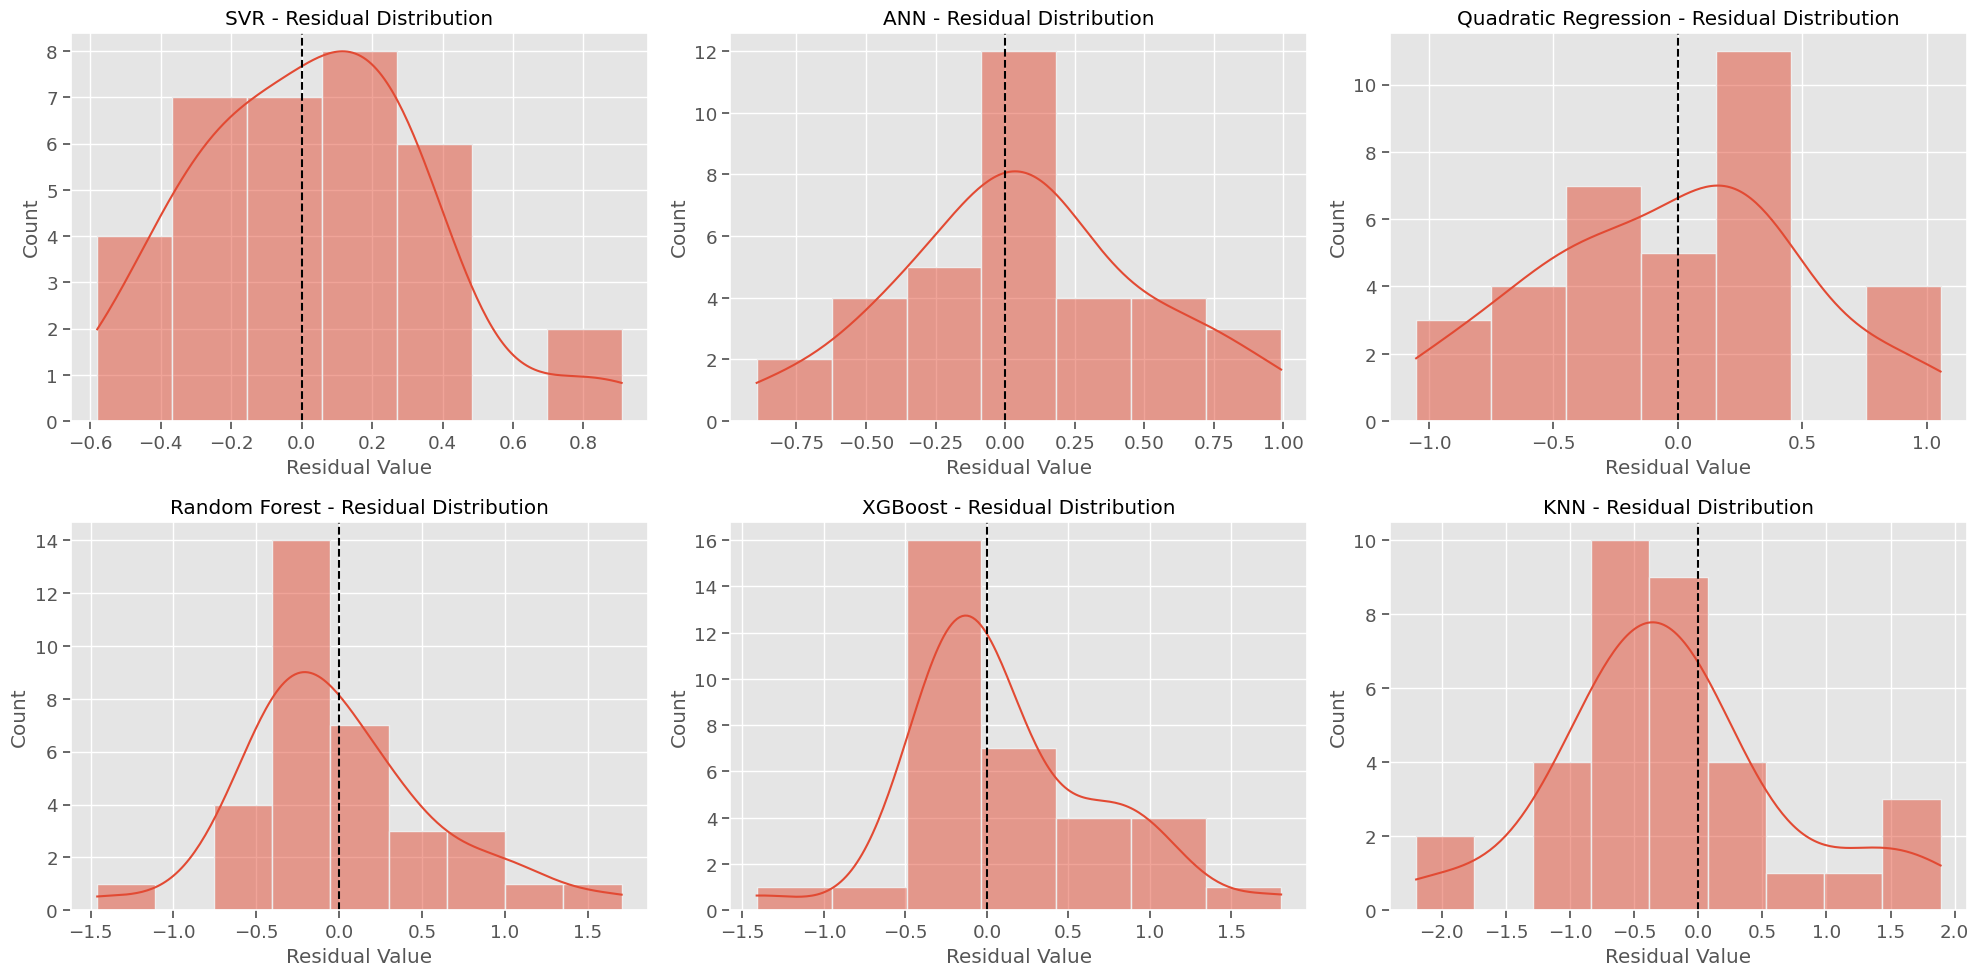

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extended model names and predictions
models = ['SVR', 'ANN', 'Quadratic Regression', 'Random Forest', 'XGBoost', 'KNN']
predictions = [y_pred_svr, y_pred_ann, y_pred_quad, y_pred_rf, y_pred_xgb, y_pred_knn]

# -------- Residual Plot --------
plt.figure(figsize=(20, 10))
for i, (model, y_pred) in enumerate(zip(models, predictions)):
    residuals = y_test - y_pred
    plt.subplot(2, 3, i+1)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.title(f'{model} - Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)

plt.tight_layout()
plt.show()

# -------- Residual Distribution Plot --------
plt.figure(figsize=(20, 10))
for i, (model, y_pred) in enumerate(zip(models, predictions)):
    residuals = y_test - y_pred
    plt.subplot(2, 3, i+1)
    sns.histplot(residuals, kde=True)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.title(f'{model} - Residual Distribution')
    plt.xlabel('Residual Value')

plt.tight_layout()
plt.show()


### Residuals Analysis Summary

#### SVR
- Residuals are centered and fairly symmetric.
- Moderate spread.
- Well-calibrated predictions.

#### ANN
- Slight right skew.
- Some underprediction.
- Mild bias present.

#### Quadratic Regression
- Skewed right with higher errors.
- Underestimates large values.
- Struggles with nonlinearities.

#### Random Forest
- Slight skew, some outliers.
- Moderate spread.
- Possible overfitting or noise sensitivity.

#### XGBoost
- Centered, tight distribution.
- Minor right skew.
- Strong and stable performance.

#### KNN
- Wide spread, heavy tails.
- High error variance.
- Weak generalization in complex areas.

#### Conclusion
- **Best models:** SVR, XGBoost  
- **Needs improvement:** Quadratic Regression, KNN


## 8. Feature Importance Analysis

Let's try to understand which features are most important for our SVR model. For non-linear kernels like RBF, direct feature importance is not available, but we can use a linear kernel to get some insights.


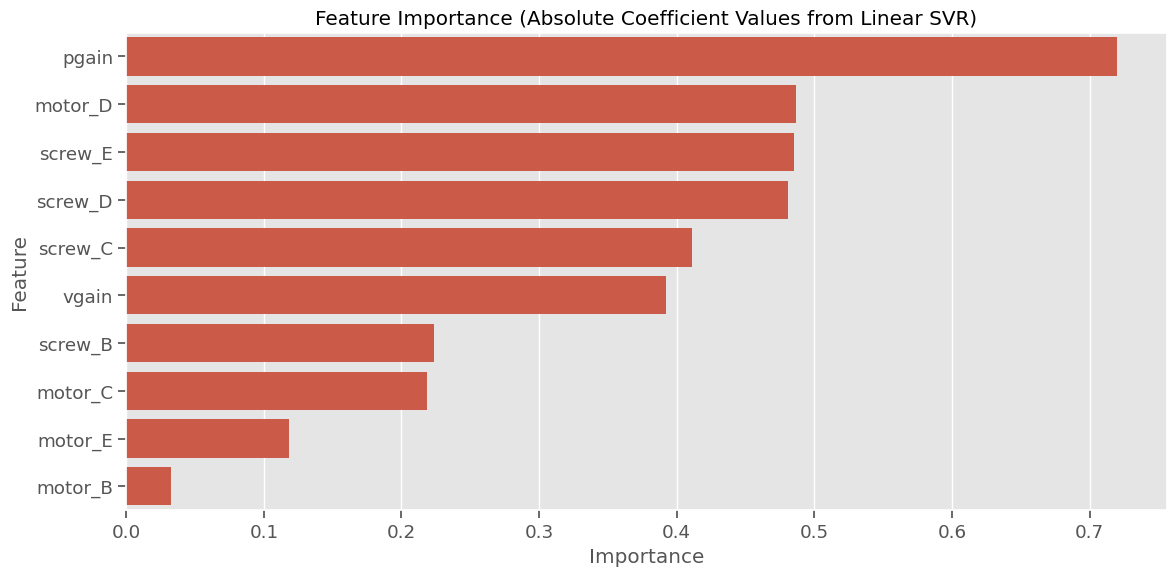

In [52]:
# Create a linear SVR to analyze feature importance
linear_svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='linear', C=1.0))
])

# Train the model
linear_svr_pipeline.fit(X_train, y_train)

# Extract feature importances (coefficients) from the linear SVR
linear_svr = linear_svr_pipeline.named_steps['regressor']
feature_importances = linear_svr.coef_[0]

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': np.abs(feature_importances)
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Absolute Coefficient Values from Linear SVR)')
plt.tight_layout()
plt.show()

## 9. Conclusion and Model Summary

Our SVR model has been trained and evaluated on the servo dataset. Here's a summary of the findings:


SVR Model Summary
----------------------------------------
Test Set RMSE: 0.3247
Test Set MAE: 0.2625
Test Set R²: 0.9564
----------------------------------------
ANN Model Summary
----------------------------------------
Test Set RMSE: 0.4476
Test Set MAE: 0.3426
Test Set R²: 0.9172
----------------------------------------
Quadratic Regression Model Summary
----------------------------------------
Test Set RMSE: 0.5239
Test Set MAE: 0.4319
Test Set R²: 0.8865
----------------------------------------
Random Forest Model Summary
----------------------------------------
Test Set RMSE: 0.5926
Test Set MAE: 0.4468
Test Set R²: 0.8548
----------------------------------------
XGBoost Model Summary
----------------------------------------
Test Set RMSE: 0.5983
Test Set MAE: 0.4222
Test Set R²: 0.8520
----------------------------------------
KNN Model Summary
----------------------------------------
Test Set RMSE: 0.9102
Test Set MAE: 0.7010
Test Set R²: 0.6575
--------------------------------

/tmp/ipykernel_26774/1611540582.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Method', x='Relative Error', data=comparison_df_sorted, palette='viridis')


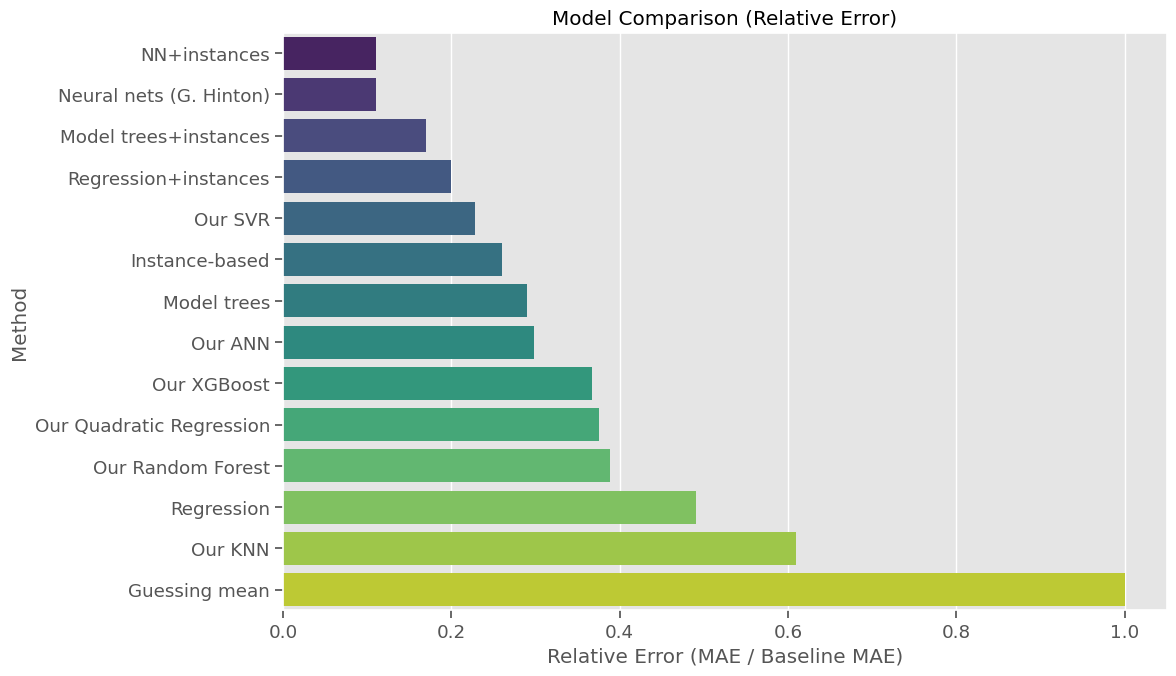

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of models and their evaluation metrics
models = ['SVR', 'ANN', 'Quadratic Regression', 'Random Forest', 'XGBoost', 'KNN']
rmse_list = [rmse_svr, rmse_ann, rmse_quad, rmse_rf, rmse_xgb, rmse_knn]
mae_list = [mae_svr, mae_ann, mae_quad, mae_rf, mae_xgb, mae_knn]
r2_list = [r2_svr, r2_ann, r2_quad, r2_rf, r2_xgb, r2_knn]

# Print model performance summary
for i, model in enumerate(models):
    print(f"{model} Model Summary")
    print("-" * 40)
    print(f"Test Set RMSE: {rmse_list[i]:.4f}")
    print(f"Test Set MAE: {mae_list[i]:.4f}")
    print(f"Test Set R²: {r2_list[i]:.4f}")
    print("-" * 40)

# ---- Comparison with other benchmark methods from dataset ----
reference_methods = [
    'Guessing mean', 'Instance-based', 'Regression', 'Model trees', 
    'Neural nets (G. Hinton)', 'Regression+instances', 'Model trees+instances', 
    'NN+instances'
]
reference_errors = [1.00, 0.26, 0.49, 0.29, 0.11, 0.20, 0.17, 0.11]

# Compute relative error for our models (MAE / baseline MAE of 1.15)
relative_errors_ours = [mae / 1.15 for mae in mae_list]

# Combine into one DataFrame
comparison_df = pd.DataFrame({
    'Method': reference_methods + [f'Our {model}' for model in models],
    'Relative Error': reference_errors + relative_errors_ours
})

# ---- Sort by Relative Error ----
comparison_df_sorted = comparison_df.sort_values(by='Relative Error', ascending=True)

# Display comparison table
print("\nComparison with other methods (Sorted by Relative Error):")
print(comparison_df_sorted)

# ---- Plot sorted relative error comparison ----
plt.figure(figsize=(12, 7))
sns.barplot(y='Method', x='Relative Error', data=comparison_df_sorted, palette='viridis')
plt.title('Model Comparison (Relative Error)')
plt.xlabel('Relative Error (MAE / Baseline MAE)')
plt.ylabel('Method')
plt.tight_layout()
plt.show()


### The best model so far for this task is : SVR

##
